In [2]:
import sys
sys.path.append('/home/daylen/xgboost/python-package')

In [3]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas
from sklearn_porter import Porter
from sklearn.externals import joblib
import xgboost as xgb
import time
# sudo apt-get install python-opencv
import cv2
%matplotlib inline

In [4]:
xgb.__path__

['/home/daylen/xgboost/python-package/xgboost']

In [5]:
cv2.__version__

'2.4.8'

In [20]:
from keras.models import Sequential
from keras.layers import Dense
import keras


## Data Preprocessing


# Crosswalks

In [7]:
% ll /home/daylen/ml_data/

total 14568392
drwxr-sr-x 2 daylen       4096 Jan 18 10:59 dec1-jan16/
-rw-r--r-- 1 daylen  591500270 Jan 29 19:08 dec1-jan16_2M_straight_test.csv
-rw-r--r-- 1 daylen      13248 Jan 29 18:36 dec1-jan16_2M_straight_test.DatasetList.pbtxt
-rw-r--r-- 1 daylen 2188384829 Jan 29 19:02 dec1-jan16_2M_straight_train.csv
-rw-r--r-- 1 daylen      48768 Jan 29 18:36 dec1-jan16_2M_straight_train.DatasetList.pbtxt
-rw-r--r-- 1 daylen  430817053 Jan 29 18:03 dec1-jan16_more_test.csv
-rw-r--r-- 1 daylen      13248 Jan 29 17:20 dec1-jan16_more_test.DatasetList.pbtxt
-rw-r--r-- 1 daylen 1591374452 Jan 29 17:57 dec1-jan16_more_train.csv
-rw-r--r-- 1 daylen      48768 Jan 29 17:20 dec1-jan16_more_train.DatasetList.pbtxt
-rw-r--r-- 1 daylen      26441 Feb  8 16:58 jan24-feb7.DatasetList.pbtxt
-rw-r--r-- 1 daylen       4608 Mar  2 01:13 jan24-feb7_test.DatasetList.pbtxt
-rw-r--r-- 1 daylen      21696 Mar  2 01:13 jan24-feb7_train.DatasetList.pbtxt
drwxr-sr-x 2 daylen       4096 Jan 18 10:58 nov19-dec13/
-r

In [8]:
FNAME_PREFIX = '/home/daylen/ml_data/xwalk_b7'

In [ ]:
def convert_csv_to_hdf5():
    print 'Loading CSVs'
    train_data = pandas.read_csv(FNAME_PREFIX + '_train.csv')
    test_data = pandas.read_csv(FNAME_PREFIX + '_test.csv')
    print 'Writing HDF5s'
    train_data.to_hdf(train_prefix + '.h5', 'train_data', mode='w')
    test_data.to_hdf(test_prefix + '.h5', 'test_data', mode='w')
    print 'Done'
# convert_csv_to_hdf5()

In [9]:
%%time
train_data = pandas.read_csv(FNAME_PREFIX + '_train.csv')
test_data = pandas.read_csv(FNAME_PREFIX + '_test.csv')

CPU times: user 41.5 s, sys: 1.72 s, total: 43.2 s
Wall time: 46.9 s


In [118]:
print train_data['label'].value_counts()
print test_data['label'].value_counts()
# print 'baseline accuracy', float(sum(train_data['label'] == 'IN_LANE')) / train_data.shape[0]

0    787073
1    735421
Name: label, dtype: int64
0    165990
1    163286
Name: label, dtype: int64


In [119]:
test_data.shape

(329276, 195)

In [120]:
np.unique(test_data.event_key).shape

(34022,)

In [121]:
def xy_split(samples):
    """
    splits row into x and y
    y can include metadata, it's not just the label
    """
    # TODO magic num
    TIMESTEPS = 10
    FEATURES_PER_TIMESTEP = 19
    ADDITIONAL_FEATURES = 2
    num_features = TIMESTEPS * FEATURES_PER_TIMESTEP + ADDITIONAL_FEATURES
    return samples.iloc[:,:num_features], samples.iloc[:,num_features:]

In [122]:
%%time
xtrain, ytrain = xy_split(train_data)
xtest, ytest = xy_split(test_data)

CPU times: user 452 ms, sys: 780 ms, total: 1.23 s
Wall time: 1.23 s


In [123]:
ytrain_encoded, ytest_encoded = ytrain['label'].as_matrix(), ytest['label'].as_matrix()

In [124]:
ytrain_encoded.shape

(1522494,)

# tensorflow!

In [129]:
model = Sequential()

model.add(Dense(units=128, activation='relu', input_dim=192))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [130]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [133]:
model.fit(xtrain.as_matrix(), ytrain_encoded, epochs=50, batch_size=512)


Epoch 1/50
1522494/1522494 [==============================] - 11s - loss: 0.1268 - acc: 0.9492    
Epoch 2/50
1522494/1522494 [==============================] - 12s - loss: 0.1267 - acc: 0.9491    
Epoch 3/50
1522494/1522494 [==============================] - 11s - loss: 0.1269 - acc: 0.9491    
Epoch 4/50
1522494/1522494 [==============================] - 9s - loss: 0.1268 - acc: 0.9492     
Epoch 5/50
1522494/1522494 [==============================] - 9s - loss: 0.1268 - acc: 0.9492     
Epoch 6/50
1522494/1522494 [==============================] - 9s - loss: 0.1269 - acc: 0.9491     
Epoch 7/50
1522494/1522494 [==============================] - 12s - loss: 0.1268 - acc: 0.9492    
Epoch 8/50
1522494/1522494 [==============================] - 11s - loss: 0.1268 - acc: 0.9494    
Epoch 9/50
1522494/1522494 [==============================] - 12s - loss: 0.1271 - acc: 0.9494    
Epoch 10/50
1522494/1522494 [==============================] - 12s - loss: 0.1267 - acc: 0.9494    
Epoch 11/

In [138]:
# Predict
ytrainpredproba = model.predict(xtrain.as_matrix(), batch_size=128)
ytestpredproba = model.predict(xtest.as_matrix(), batch_size=128)


In [139]:
ytrainpred = np.rint(ytrainpredproba)
ytestpred = np.rint(ytestpredproba)

## P/R curves


In [ ]:
np.savetxt('/mnt/flashblade/daylen/debug_pr_curve_labels.txt', ytest_encoded)

In [ ]:
np.savetxt('/mnt/flashblade/daylen/debug_pr_curve_preds.txt', ytestpredproba)

Average precision-recall score: 0.84


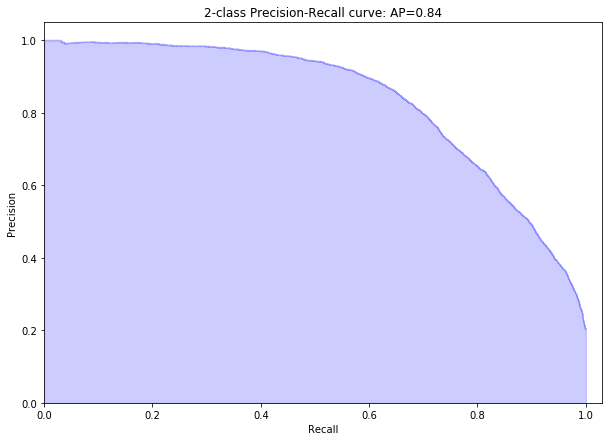

In [87]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(ytest_encoded, ytestpredproba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(ytest_encoded, ytestpredproba)
plt.figure(figsize=(10, 7))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1.05])
plt.xlim([0, 1.03])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [140]:
# Performance per category
print 'TRAIN'
for category_name in np.unique(train_data.sample_type):
    idxs = ytrain.loc[ytrain.sample_type == category_name].index.tolist()
    print category_name, '=', sklearn.metrics.accuracy_score(ytrain_encoded[idxs], ytrainpred[idxs])
print 'TEST'
for category_name in np.unique(test_data.sample_type):
    idxs = ytest.loc[ytest.sample_type == category_name].index.tolist()
    print category_name, '=', sklearn.metrics.accuracy_score(ytest_encoded[idxs], ytestpred[idxs])


TRAIN
negative_after_cross = 0.977338403042
negative_before_cross = 0.785380694404
negative_inside_backwards = 0.993259543068
negative_inside_lateral = 0.9703136351
negative_never_inside = 0.954195195994
positive_before = 0.787097076242
positive_inside = 0.986495854723
TEST
negative_after_cross = 0.977677538746
negative_before_cross = 0.785696821516
negative_inside_backwards = 0.993009876127
negative_inside_lateral = 0.948628219485
negative_never_inside = 0.952290561044
positive_before = 0.780610778756
positive_inside = 0.982837096917
